# Conditional edges

Conditional edges allow you to select which node will be executed next, after the current one.

In [3]:
from typing import Literal, TypedDict

from langgraph.types import Command
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    pass

## Definition

The are two main ways to define the conditional edges:

- You can annotate node outputs as a `langgraph.types.Command` with a literal that specifies the possible next nodes as a generic argument. Such a node must return a `langgraph.types.Command` containing a state update and next node to be executed.
- The `add_conditional_edges` method of the builder, takes the method that must return the names of the possible subsequent nodes.

---

The following cell combines both definitions: `node_a` is referenced by the `add_conditional_edges` and itself selects either `END` or `node_b`.

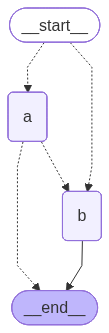

In [7]:
def conditional_edge(state: State) -> Literal["a", "b"]:
    return state


def node_a(state: State) -> Command[Literal["b", "__end__"]]:
    return state


def node_b(state: State) -> State:
    return state


(
    StateGraph(State)
    .add_node("a", node_a)
    .add_node("b", node_b)

    .add_conditional_edges(START, conditional_edge)
    .add_edge("a", END)
    .compile()
)

## Explicit syntax

The most explicit syntax allows to define the arbitrary outputs for the decision node, regardless of where it will be applied. Using the `path_map` method of the `StateGraph.add_conditional_edges`, you can specify which outputs of the callable implementing the decision will invoke which the subsequent node. 

---

The following cell defines the `decision` that annotated the return of either `path1` or `path2`. When the conditional edge based on this function is defined in the graph, the subsequent nodes are mapped to the outputs of the `decision` in the `path_map` argument.

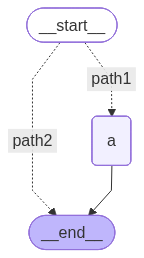

In [10]:
def decision(state: State) -> Literal["path1", "path2"]:
    return "path1"


def node_a(state: State):
    return {}


(
    StateGraph(State)
    .add_node("a", node_a)

    .add_conditional_edges(
        soruce=START,
        path=decision,
        path_map={
            "path1": "a",
            "path2": END
        }
    )
    .add_edge("a", END)
    .compile()
)

In [16]:
print(StateGraph.add_conditional_edges.__doc__)

Add a conditional edge from the starting node to any number of destination nodes.

Args:
    source: The starting node. This conditional edge will run when
        exiting this node.
    path: The callable that determines the next node or nodes.

        If not specifying `path_map` it should return one or more nodes.

        If it returns `'END'`, the graph will stop execution.
    path_map: Optional mapping of paths to node names.

        If omitted the paths returned by `path` should be node names.

Returns:
    Self: The instance of the graph, allowing for method chaining.

!!! warning
    Without type hints on the `path` function's return value (e.g., `-> Literal["foo", "__end__"]:`)
    or a path_map, the graph visualization assumes the edge could transition to any node in the graph.




## Goto several

To execute several nodes after a given conditional node, return a list of values containing desired nodes.

---

The following cell defines a graph with a conditional node that can invoke three other nodes, but randomly invokes two of them.

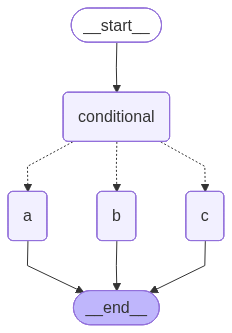

In [8]:
from random import sample


def node_a(state: State) -> State:
    print("node a")
    return state


def node_b(state: State) -> State:
    print("node b")
    return state


def node_c(state: State) -> State:
    print("node c")
    return state


def conditional(state: State) -> Command[Literal["a", "b", "c"]]:
    return Command(goto=sample(["a", "b", "c"], k=2))


graph = (
    StateGraph(State)
    .add_node("conditional", conditional)

    .add_node("a", node_a)
    .add_node("b", node_b)
    .add_node("c", node_c)

    .add_edge("__start__", "conditional")
    .add_edge("a", "__end__")
    .add_edge("b", "__end__")
    .add_edge("c", "__end__")

    .compile()
)
graph

The following cell invokes the graph for a several times.

In [9]:
for i in range(3):
    print("=" * 80)
    graph.invoke({})

node a
node b
node a
node c
node a
node c


## Send to node

The conditional edge that returns `langgraph.types.Send` sends the specified data to the specified node.

Check official description in [Send](https://reference.langchain.com/python/langgraph/types/#langgraph.types.StateSnapshot.tasks) section of the official documentation.

---

The following cell defines `route` function that sends `{"out": "to target node"}` to the `target_node`.

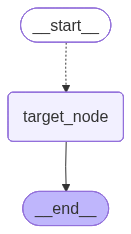

In [20]:
from langgraph.types import Send


class OverallState(TypedDict):
    ans: str


def route(state: OverallState) -> Send:
    return Send("target_node", {"out": "to target node"})


def target_node(state: dict) -> OverallState:
    print("State for the target node", state)
    return OverallState(ans="This is from target node")


graph = (
    StateGraph(OverallState)
    .add_node("target_node", target_node)

    .add_conditional_edges(START, route, ["target_node"])
    .add_edge("target_node", END)

    .compile()
)
graph

The invocation of the graph shows

In [21]:
graph.invoke(OverallState(ans="input"))

State for the target node {'out': 'to target node'}


{'ans': 'This is from target node'}